# 0. Setup

In [ ]:
!nvidia-smi -L

In [ ]:
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
import csv
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix
from misc.helpers import find_model_weights, calculate_label_distributions, prev_img, prev_img_gray, trans_norm2tensor, find_csv_files, get_image_paths_from_csv, get_image_paths_from_dir, get_image_filenames_by_label, create_vit_model
from misc.visualization import *
from scipy.stats import entropy
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from model.vit_for_small_dataset import ViT
from utils.imageQualityDataset import ImageQualityDataset
from utils.imageAttentionGlobalAvgDataset import ImageAttentionGlobalAvgDataset



# 1. Build Model

In [ ]:
image_size=256
patch_size=16
num_classes=5
depth = 6

In [ ]:
model = create_vit_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Define the normalization parameters (mean and std)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define the transformation including normalization
img2tensor_normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Beginn Analysis

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
class TransformedImageDataset(Dataset):
    def __init__(self, images, transform_funcs, crop_size=(50, 50), crop_position=None):
        """
        Args:
        - images (list): List of image file paths or PIL images.
        - transform_funcs (list): list of Transformation functions (e.g., apply_compression_patch, apply_blur_patch).
        - crop_size (tuple): Size of the cropped area.
        - crop_position (str): List of crop positions for transformation (e.g., 'center', 'top-left', etc.).
        """
        self.images = images
        self.transform_funcs = transform_funcs
        self.crop_size = crop_size
        self.crop_position = crop_position or None
        
        # Calculate total transformations per image
        self.transforms_per_image = []
        for transform_func in transform_funcs:
            self.transforms_per_image.append((transform_func, self.crop_position))
        
        print(f"crop positions: {self.crop_position}")
        print(f"Total transformations per image: {len(self.transforms_per_image)}")
        print(f"Total images: {len(self.images)}")

        # Define the transformation including normalization
        self.preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256)])
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.images[idx]
        img = Image.open(img_path).convert("RGB") if isinstance(img_path, str) else img_path
        # Preprocess the image
        img = self.preprocess(img)
        org_img = img.copy()
        # Apply all the transformations with the specified crop position and level parameters
        transformed_imgs = []
        for transform_func, crop_pos in self.transforms_per_image:
            transformed_img = transform_func(img, crop_size=self.crop_size, crop_pos=crop_pos)
            transformed_imgs.append(transformed_img)
        
        # Return the original image and an array of the transformed images
        return org_img, transformed_imgs


In [49]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image, ImageFilter
import random
from io import BytesIO
from functools import partial  # Import partial to handle function parameters


csv_file = 'assets/Test/Obs0.csv'

img_directory_path = 'assets/Test/DSX'

# Get the list of image paths from the CSV file
# Initialize a list to store the image paths
image_paths = []

# Read the CSV file and extract the image filenames
with open(csv_file, 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip the header row
    for row in reader:
        image_filename = row[0]
        vote = row[1]
        # fitler only images with vote of 5
        if int(vote) == 5:
            image_path = os.path.join(img_directory_path, image_filename)
            image_paths.append(image_path)

            
# Transformationen und Levels definieren
transform_funcs = [
    transformations.apply_occlusion_patch,
    partial(transformations.apply_compression_patch, quality=0),  # Use `partial` to set parameters
    transformations.apply_grayscale_patch,
    partial(transformations.apply_blur_patch, blur_radius=6)  # Use `partial` to set parameters
]

# Manually assign names to partial functions for use in plotting
for func in transform_funcs:
    if isinstance(func, partial):
        func.__name__ = f"{func.func.__name__}"  # Set a name for partial function


crop_position = "center"
# get transformation function name from the function name
crop_size = (96,96)

# Dataset initialisieren
dataset = TransformedImageDataset(
    images=image_paths[:30], # images for testing
    transform_funcs=transform_funcs,
    crop_size=crop_size,
    crop_position=crop_position
)

crop positions: center
Total transformations per image: 4
Total images: 30


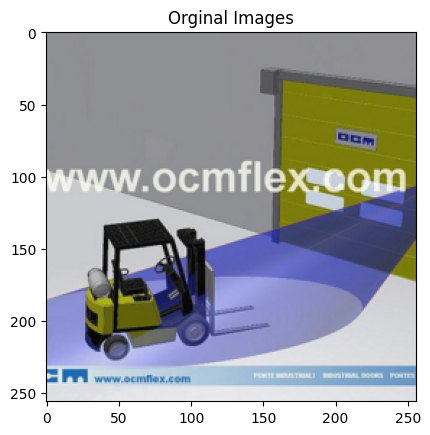

In [52]:
# Example single image
seed = random.randint(0, len(dataset)-1)
org_img, _ = dataset[seed]

plt.imshow(org_img)
plt.title(f"Orginal Images")
plt.show()

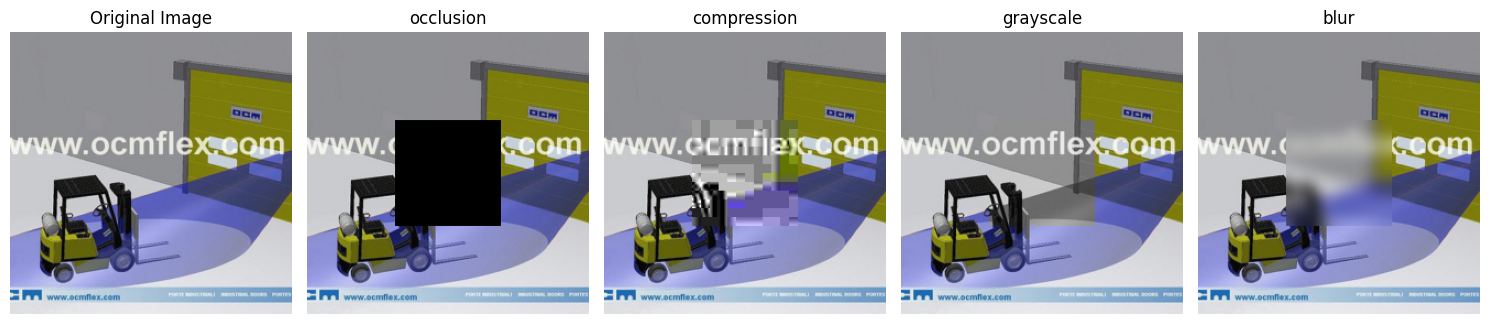

In [53]:
import matplotlib.pyplot as plt

# Example: Show all levels in 1 row
fig, axes = plt.subplots(1, len(transform_funcs) + 1, figsize=(15, 5))

# Get the original and transformed images
org_img, trans_imgs = dataset[seed]

# Display the original image with a title
axes[0].imshow(org_img)
axes[0].set_title("Original Image")
for ax in axes:
     ax.axis('off')



# Loop over the transformed images and display each with the function name as the title
for i, (img, (transform_func, _)) in enumerate(zip(trans_imgs, dataset.transforms_per_image)):
    # Get the name of the transformation function
    transform_name = transform_func.__name__.split("_")[1]
    axes[i + 1].imshow(img)
    axes[i + 1].set_title(transform_name)

plt.tight_layout()
plt.show()


In [ ]:
weights_dir = "results/weights/Cross-Entropy_3_Iter_var_0.4/FINAL"
# List of different weight files
weight_files = [os.path.join(weights_dir, f'AIO{i}.pth') for i in range(1,6)]
weight_file = weight_files[0]
print(weight_file)

output_dir = f"results/Attention_maps/compare_transformations/{crop_position}"
# create output_dir if not exists
os.makedirs(output_dir, exist_ok=True)
layer_idx = 5


In [ ]:
import torch
import numpy as np

def calculate_average_attention_in_crop(attention_map, crop_bbox, patch_size):
    """
    Calculate the average attention within a specified crop region.

    Args:
    - attention_map (torch.Tensor or np.ndarray): Attention map of shape (H, W).
    - crop_bbox (tuple): Bounding box coordinates (left, top, right, bottom) in pixel space.
    - patch_size (int): Size of each patch in pixels.

    Returns:
    - float: Average attention within the cropped region.
    """

    # Convert the bounding box from pixel space to patch space
    left, top, right, bottom = [coord // patch_size for coord in crop_bbox]
    print("Left, Top, Right, Bottom", left, top, right, bottom)
    # print(left, top, right, bottom)
    # Ensure that the attention_map is in numpy format for easier indexing
    if isinstance(attention_map, torch.Tensor):
        attention_map = attention_map.cpu().numpy()

    # Extract the attention map within the crop region
    crop_attention = attention_map[top:bottom, left:right]

    # Calculate the average attention in the cropped region
    avg_attention = np.mean(crop_attention)
    
    return avg_attention

def calculate_sum_attention_in_crop(attention_map, crop_bbox, patch_size):
    """
    Calculate the sum of attention within a specified crop region.

    Args:
    - attention_map (torch.Tensor or np.ndarray): Attention map of shape (H, W).
    - crop_bbox (tuple): Bounding box coordinates (left, top, right, bottom) in pixel space.
    - patch_size (int): Size of each patch in pixels.

    Returns:
    - float: Sum of attention within the cropped region.
    """

    # Convert the bounding box from pixel space to patch space
    left, top, right, bottom = [coord for coord in crop_bbox]
    print("Left, Top, Right, Bottom", left, top, right, bottom)
    # print(left, top, right, bottom)

    # Ensure that the attention_map is in numpy format for easier indexing
    if isinstance(attention_map, torch.Tensor):
        attention_map = attention_map.cpu().numpy()

    # Extract the attention map within the crop region
    crop_attention = attention_map[top:bottom, left:right]
    # print(f"Crop Atenntion shape: {crop_attention.shape}")

    # print(f"Crop Attention: {crop_attention}")
    # print(f"Crop Attention Sum: {crop_attention.sum()}")
    # print(f"Crop Attention Mean: {crop_attention.mean()}")




    # Calculate the sum of attention in the cropped region
    sum_attention = np.sum(crop_attention)

    return sum_attention


In [ ]:
def preprocess_img_gray(img: Image.Image) -> Image.Image:
    """
    Process the image for previewing purposes with grayscale and contrast adjustment.

    This function applies transformations to resize and center crop the input image to a specified size.
    It then converts the image to grayscale and enhances the contrast by scaling the luminance values.
    
    Parameters:
    img (PIL.Image): The input image.

    Returns:
    img_bw_contrast_rgb (PIL.Image): The processed image with enhanced contrast in RGB format.
    """

    # Convert the image to grayscale
    img_bw = img.convert('L')

    # Convert grayscale image to YCbCr color space
    img_ycbcr = img_bw.convert('YCbCr')
    y, cb, cr = img_ycbcr.split()
    # Convert Y channel to NumPy arrays
    y_array = np.array(y)

    # Perform contrast adjustment on the Y component
    y_array = np.clip(y_array * 2.0, 0, 255).astype(np.uint8)

    # Merge the adjusted Y, Cb, Cr components back into an image
    img_bw_contrast = Image.merge('YCbCr', (Image.fromarray(y_array), cb, cr))

    # Convert the image back to RGB for display
    img_bw_contrast_rgb = img_bw_contrast.convert('RGB')
    
    return img_bw_contrast_rgb

In [ ]:
fontsize=30

In [ ]:
attention_data_avg = []
attention_data_sum = []

for image_idx in range(len(dataset)):

    # Creating a subplot
    fig, axes = plt.subplots(len(weight_files)+1, len(transform_funcs)+1, figsize=((len(transform_funcs)+1)*7, (len(weight_files)+1)*5))
    # fig.suptitle("Attention Map Comparison Across Transformations and AIOs", fontsize=fontsize+2)

    for ax in axes.flatten():
        ax.axis('off')


    org_img, trans_imgs = dataset[image_idx]
    org_img_pre = preprocess_img_gray(org_img)

    # Displaying the original image and transformed images in the first row
    axes[0, 0].imshow(org_img)
    axes[0, 0].set_title("Original", fontsize=fontsize)

    for i, (img, (transform_func,_)) in enumerate(zip(trans_imgs, dataset.transforms_per_image)):
        transform_name = transform_func.__name__.split("_")[1]
        # First Character of transform_name in Uppercase
        transform_name = transform_name[0].upper() + transform_name[1:]
        axes[0, i+1].imshow(img)
        axes[0, i+1].set_title(transform_name, fontsize=fontsize)

    # Displaying the attention maps for each weight_file in the next row
    for i, weight_file in enumerate(weight_files):
        model = create_vit_model(weights_path=weight_file)
        model.eval()
        model.to(device)
        weight_name = os.path.basename(weight_file).split('.')[0]

        # Calculate attention maps for the original and transformed images
        img_pre_org = trans_norm2tensor(org_img, image_size, transformation_function=None)
        _, attention_org = get_attention_maps(model, img_pre_org, patch_size, device)
        # get attention in layer_idx layer
        layer_attention_org = attention_org[layer_idx]
        # normalize the mean head attention (mean of all heads, axis=0)
        layer_mean_org = normalize_attention_maps(np.mean(layer_attention_org, axis=0))
        print(f"Layer Mean Org Shape: {layer_mean_org.shape}")
        # print(f"Layer Mean Org: {layer_mean_org}")
        # print(f"Layer Mean Org Sum: {layer_mean_org.sum()}")
        # print min max value of layer_mean_org
        print(f"Layer Mean Org Min: {layer_mean_org.min()}")
        print(f"Layer Mean Org Max: {layer_mean_org.max()}")



        heatmap = sns.heatmap(layer_mean_org, cmap="jet", alpha=0.7, ax=axes[i+1, 0])

        # Adjust colorbar fontsize
        cbar = heatmap.collections[0].colorbar  # Access the colorbar of the heatmap
        cbar.ax.tick_params(labelsize=fontsize-2)  # Adjust the fontsize of the colorbar ticks
        cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])

        axes[i+1, 0].imshow(org_img_pre)
        axes[i+1, 0].set_title(f"Attention Map {weight_name}", fontsize=fontsize)

        # Calculate attention maps for the transformed images
        imgs_pre_trans = [trans_norm2tensor(img, image_size, transformation_function=None) for img in trans_imgs]
        atts_trans = [get_attention_maps(model, img_pre_trans, patch_size, device)[1] for img_pre_trans in imgs_pre_trans]
        layer_atts_trans = [att[layer_idx] for att in atts_trans]
        layer_mean_trans = [normalize_attention_maps(np.mean(layer_att, axis=0)) for layer_att in layer_atts_trans]

        crop_bbox = transformations.get_random_bbox(org_img, crop_size=crop_size, crop_pos=crop_position)
        # print(f"Crop BBox: {crop_bbox}")

        # Calculate the sum of attention within the cropped region
        sum_attention_org = calculate_sum_attention_in_crop(
            attention_map=layer_mean_org, 
            crop_bbox=crop_bbox, 
            patch_size=patch_size)
        
        # Store the data in the dictionary
        attention_data_sum.append({"Transformation": f"original", "Attention Sum": sum_attention_org, "Weight File": weight_name})
        # print(f"Original Attention: {sum_attention_org}")
        # Store average attention for each transformation level and weight
        for j, (lmt, img, (transform_func,_)) in enumerate(zip(layer_mean_trans, trans_imgs, dataset.transforms_per_image)):

            # Calculate the sum of attention within the cropped region
            sum_attention = calculate_sum_attention_in_crop(
                attention_map=lmt, 
                crop_bbox=crop_bbox, 
                patch_size=patch_size)

            # Store the data in the dictionary
            attention_data_sum.append({"Transformation": f"{transform_func.__name__.split('_')[1]}", "Attention Sum": sum_attention, "Weight File": weight_name})
            # print(f"Transfromed Attention ({transform_func.__name__.split('_')[1]}): {sum_attention}")

            # Calculate difference in attention
            diff_att = (lmt - layer_mean_org)
            diff_att_round = np.round(diff_att, 2)

            # Create the heatmap for the difference in attention
            heatmap = sns.heatmap(diff_att_round, cmap="seismic", alpha=0.7, ax=axes[i+1, j+1], vmin=-1, vmax=1)

            # Adjust the colorbar fontsize
            cbar = heatmap.collections[0].colorbar  # Access the colorbar of the heatmap
            cbar.ax.tick_params(labelsize=fontsize-2)  # Set the fontsize for the colorbar ticks
            cbar.set_ticks([-1, -0.5, 0, 0.5, 1])

            # Display the transformed image on top of the heatmap
            axes[i+1, j+1].imshow(preprocess_img_gray(img))

            # Format the transformation name (capitalize first letter)
            transform_name = transform_func.__name__.split("_")[1]
            transform_name = transform_name[0].upper() + transform_name[1:]

            # Set the title for the subplot with the desired fontsize
            # axes[i+1, j+1].set_title(f"{transform_name} - Attention Map {weight_name} (diff)", fontsize=fontsize)
            axes[i+1, j+1].set_title(f"{transform_name} - Difference", fontsize=fontsize)

        
        # Clear the model from memory
        del model

    # Adjust layout of subplots
    plt.tight_layout()
    # Define output path
    output_path = os.path.join(output_dir, f"attention_map_comparison_patch_transformations_img_{image_idx}_layer_{layer_idx}_.png")
    print(f"Saving image to {output_path}")
    plt.savefig(output_path, dpi=300)
    plt.close(fig)

# Create a DataFrame for boxplot
attention_df_sum = pd.DataFrame(attention_data_sum)
attention_df_avg = pd.DataFrame(attention_data_avg)

In [ ]:
import pandas as pd
import os

# Convert attention_data_avg to a DataFrame
attention_df_avg = pd.DataFrame(attention_data_sum)

# Define the order of the transformations
transformations_order = ["original", "occlusion", "compression", "grayscale", "blur"]

# Ensure the 'Transformation' column is of a category type with the defined order
attention_df_avg['Transformation'] = pd.Categorical(attention_df_avg['Transformation'], categories=transformations_order, ordered=True)

# Sort the DataFrame by 'Transformation'
attention_df_avg.sort_values('Transformation', inplace=True)

# Create a pivot table for Average Attention
pivot_table_avg = pd.pivot_table(
    attention_df_avg,
    values="Attention Sum",    # Values to summarize
    index="Transformation",    # Rows
    columns="Weight File",     # Columns
    aggfunc="mean"             # Aggregation function
)

# Optionally format the table (e.g., rounding values for readability)
pivot_table_avg = pivot_table_avg.round(3)

# Save the pivot table as a CSV for inspection
pivot_table_avg.to_csv(os.path.join(output_dir, "average_attention_summary.csv"))

# Print the table to verify
print(pivot_table_avg)


In [ ]:
import pandas as pd
import os

# Convert attention_data_avg to a DataFrame
attention_df_avg = pd.DataFrame(attention_data_sum)

# Define the order of the transformations
transformations_order = ["original", "occlusion", "compression", "grayscale", "blur"]

# Ensure the 'Transformation' column is of a category type with the defined order
attention_df_avg['Transformation'] = pd.Categorical(attention_df_avg['Transformation'], categories=transformations_order, ordered=True)

# Sort the DataFrame by 'Transformation'
attention_df_avg.sort_values('Transformation', inplace=True)

# Create a pivot table for Average Attention
pivot_table_avg = pd.pivot_table(
    attention_df_avg,
    values="Attention Sum",    # Values to summarize
    index="Transformation",    # Rows
    columns="Weight File",     # Columns
    aggfunc="mean"             # Aggregation function  

)

# Round the original pivot table values to 2 decimal places
pivot_table_avg = pivot_table_avg.round(2)
# Save the original pivot table
pivot_table_avg.to_csv(os.path.join(output_dir, "average_attention_summary.csv"))

# Calculate percentage change relative to the "original" row
original_values = pivot_table_avg.loc["original"].round(2)

# Calculate percentage change
percentage_change_table = (pivot_table_avg - original_values) / original_values * 100

# Format the table with original values and percentage changes
formatted_table = pivot_table_avg.copy()

# Iterate over transformations and modify the table
for transformation in transformations_order:
    if transformation == "original":
        # Round the original values to 2 decimal places
        formatted_table.loc[transformation] = formatted_table.loc[transformation].round(2)
    else:
        # Add percentage change values and append '%'
        formatted_table.loc[transformation] = (
            percentage_change_table.loc[transformation]
            .round(2)  # Round percentage change
            .astype(str)  # Convert to string
            + " %"  # Append '%'
        )

# Save the formatted table to a CSV
formatted_table.to_csv(os.path.join(output_dir, "formatted_percentage_change_attention_summary.csv"))

# Print the formatted table for verification
print("Formatted Table with Original Values and Percentage Changes:")
print(formatted_table)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a directory to save the boxplots if it doesn't exist
boxplot_dir = os.path.join(output_dir, "boxplots")
os.makedirs(boxplot_dir, exist_ok=True)

# Calculate the global y-axis limits for consistent scale
y_min = attention_df_avg["Attention Sum"].min() - 1000
y_max = attention_df_avg["Attention Sum"].max() + 1000

# Iterate over each "Weight File" and create a boxplot for each
for weight_file in attention_df_avg['Weight File'].unique():
    # Filter the DataFrame for the current weight file
    filtered_df = attention_df_avg[attention_df_avg['Weight File'] == weight_file]
    
    # Create a boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=filtered_df,
        x="Transformation",
        y="Attention Sum",
        order=transformations_order,  # Ensures the correct order of the x-axis
        palette="Set2"
    )
    
    # Set consistent y-axis limits
    plt.ylim(y_min, y_max)
    
    # Add titles and labels
    plt.title(f"Attention Sum Distribution for {weight_file}", fontsize=14)
    plt.xlabel("Transformation", fontsize=12)
    plt.ylabel("Attention Sum", fontsize=12)
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability
    
    # Save the plot
    boxplot_path = os.path.join(boxplot_dir, f"boxplot_{weight_file.replace(' ', '_')}.png")
    plt.tight_layout()
    plt.savefig(boxplot_path)
    plt.close()  # Close the figure to free up memory

    print(f"Saved boxplot for {weight_file} at {boxplot_path}")


In [ ]:
import pandas as pd
import os

# Convert attention_data_avg to a DataFrame
attention_df_avg = pd.DataFrame(attention_data_sum)

# Define the order of the transformations
transformations_order = ["original", "occlusion", "compression", "grayscale", "blur"]

# Ensure the 'Transformation' column is of a category type with the defined order
attention_df_avg['Transformation'] = pd.Categorical(attention_df_avg['Transformation'], categories=transformations_order, ordered=True)

# Sort the DataFrame by 'Transformation'
attention_df_avg.sort_values('Transformation', inplace=True)

# Separate original and transformed rows
original_attention = attention_df_avg[attention_df_avg['Transformation'] == 'original']
transformed_attention = attention_df_avg[attention_df_avg['Transformation'] != 'original']

# Function to compute mean ± std
def mean_std_formatter(x):
    mean = x.mean()
    std = x.std()
    return f"{mean:.2f} (+/- {std:.2f})"

# Create a pivot table for transformed rows with mean ± std
pivot_table_transformed = transformed_attention.pivot_table(
    values="Attention Sum",
    index="Transformation",
    columns="Weight File",
    aggfunc=lambda x: mean_std_formatter(x)
)

# Create a pivot table for original rows (mean only, no std)
pivot_table_original = original_attention.pivot_table(
    values="Attention Sum",
    index="Transformation",
    columns="Weight File",
    aggfunc="mean"
)

# Combine the original and transformed pivot tables
pivot_table_combined = pd.concat([pivot_table_original, pivot_table_transformed])

# Save the pivot table as a CSV for inspection
output_path = os.path.join(output_dir, "attention_comparison_with_original.csv")
pivot_table_combined.to_csv(output_path)

# Print the table to verify
print(pivot_table_combined)


In [ ]:
import pandas as pd
import os

# Convert attention_data_avg to a DataFrame
attention_df_avg = pd.DataFrame(attention_data_sum)

# Define the order of the transformations
transformations_order = ["original", "occlusion", "compression", "grayscale", "blur"]

# Ensure the 'Transformation' column is of a category type with the defined order
attention_df_avg['Transformation'] = pd.Categorical(attention_df_avg['Transformation'], categories=transformations_order, ordered=True)

# Sort the DataFrame by 'Transformation'
attention_df_avg.sort_values('Transformation', inplace=True)

# Separate original and transformed rows
original_attention = attention_df_avg[attention_df_avg['Transformation'] == 'original']
transformed_attention = attention_df_avg[attention_df_avg['Transformation'] != 'original']

# Function to compute mean ± std (% of mean)
def mean_std_percentage_formatter(x):
    mean = x.mean()
    mean_percentage = 

    std = x.std()
    std_percentage = (std / mean) * 100 if mean != 0 else 0  # Avoid division by zero
    return f"{mean:.2f} (+/- {std_percentage:.2f}%)"

# Create a pivot table for transformed rows with mean ± std as a percentage of the mean
pivot_table_transformed = transformed_attention.pivot_table(
    values="Attention Sum",
    index="Transformation",
    columns="Weight File",
    aggfunc=lambda x: mean_std_percentage_formatter(x)
)

# Create a pivot table for original rows (mean only, no std as there’s only one row per "Weight File")
pivot_table_original = original_attention.pivot_table(
    values="Attention Sum",
    index="Transformation",
    columns="Weight File",
    aggfunc="mean"
)

# Round the "original" values to 2 decimal places for consistency
pivot_table_original = pivot_table_original.round(2)

# Combine the original and transformed pivot tables
pivot_table_combined = pd.concat([pivot_table_original, pivot_table_transformed])

# Save the pivot table as a CSV for inspection
output_path = os.path.join(output_dir, "attention_comparison_with_std_percentage.csv")
pivot_table_combined.to_csv(output_path)

# Print the table to verify
print("Pivot Table with Mean ± Std as % of Mean:")
print(pivot_table_combined)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_avg, annot=True, cmap="jet", fmt=".3f")
plt.title("Average of Total Attention for Central Area by Transformation and AIO")
plt.ylabel("Transformation")
plt.xlabel("Weight File")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "average_attention_heatmap.png"))
plt.show()


-----------------------------------